# Programming for Data Science and Artificial Intelligence

## Deep Learning - PyTorch - Transfer Learning for Computer Vision

- Key paper on transfer learning - https://arxiv.org/abs/1411.1792
- PyTorch tutorials - https://pytorch.org/tutorials/

### Transfer Learning theory and practice

Edited from https://cs231n.github.io/transfer-learning/

In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest. The three major Transfer Learning scenarios look as follows:

- **ConvNet as fixed feature extractor**. Take a ConvNet pretrained on ImageNet, remove the last fully-connected layer (this layer’s outputs are the 1000 class scores for a different task like ImageNet), then treat the rest of the ConvNet as a fixed feature extractor for the new dataset. In an AlexNet, this would compute a 4096-D vector for every image that contains the activations of the hidden layer immediately before the classifier. We call these features CNN codes. It is important for performance that these codes are ReLUd (i.e. thresholded at zero) if they were also thresholded during the training of the ConvNet on ImageNet (as is usually the case). Once you extract the 4096-D codes for all images, train a linear classifier (e.g. Linear SVM or Softmax classifier) for the new dataset.

- **Fine-tuning the ConvNet**. The second strategy is to not only replace and retrain the classifier on top of the ConvNet on the new dataset, but to also fine-tune the weights of the pretrained network by continuing the backpropagation. It is possible to fine-tune all the layers of the ConvNet, or it’s possible to keep some of the earlier layers fixed (due to overfitting concerns) and only fine-tune some higher-level portion of the network. This is motivated by the observation that the earlier features of a ConvNet contain more generic features (e.g. edge detectors or color blob detectors) that should be useful to many tasks, but later layers of the ConvNet becomes progressively more specific to the details of the classes contained in the original dataset. In case of ImageNet for example, which contains many dog breeds, a significant portion of the representational power of the ConvNet may be devoted to features that are specific to differentiating between dog breeds.

- **Pretrained models**. Since modern ConvNets take 2-3 weeks to train across multiple GPUs on ImageNet, it is common to see people release their final ConvNet checkpoints for the benefit of others who can use the networks for fine-tuning. For example, the Caffe library has a Model Zoo where people share their network weights.


**When and how to fine-tune?** How do you decide what type of transfer learning you should perform on a new dataset? This is a function of several factors, but the two most important ones are the **size of the new dataset (small or big)**, and **its similarity to the original dataset** (e.g. ImageNet-like in terms of the content of images and the classes, or very different, such as microscope images). Keeping in mind that ConvNet features are more generic in early layers and more original-dataset-specific in later layers, here are some common rules of thumb for navigating the 4 major scenarios:

- *New dataset is small and similar to original dataset*. Since the data is small, it is not a good idea to fine-tune the ConvNet due to overfitting concerns. Since the data is similar to the original data, we expect higher-level features in the ConvNet to be relevant to this dataset as well. Hence, the best idea might be to train a linear classifier on the CNN codes.

- *New dataset is large and similar to the original dataset*. Since we have more data, we can have more confidence that we won’t overfit if we were to try to fine-tune through the full network.

- *New dataset is small but very different from the original dataset*. Since the data is small, it is likely best to only train a linear classifier. Since the dataset is very different, it might not be best to train the classifier form the top of the network, which contains more dataset-specific features. Instead, it might work better to train the SVM classifier from activations somewhere earlier in the network.

- *New dataset is large and very different from the original dataset*. Since the dataset is very large, we may expect that we can afford to train a ConvNet from scratch. However, in practice it is very often still beneficial to initialize with weights from a pretrained model. In this case, we would have enough data and confidence to fine-tune through the entire network.

**Practical advice**. There are a few additional things to keep in mind when performing Transfer Learning:

- **Constraints from pretrained models**. Note that if you wish to use a pretrained network, you may be slightly constrained in terms of the architecture you can use for your new dataset. For example, you can’t arbitrarily take out Conv layers from the pretrained network. However, some changes are straight-forward: Due to parameter sharing, you can easily run a pretrained network on images of different spatial size. This is clearly evident in the case of Conv/Pool layers because their forward function is independent of the input volume spatial size (as long as the strides “fit”). In case of FC layers, this still holds true because FC layers can be converted to a Convolutional Layer: For example, in an AlexNet, the final pooling volume before the first FC layer is of size [6x6x512]. Therefore, the FC layer looking at this volume is equivalent to having a Convolutional Layer that has receptive field size 6x6, and is applied with padding of 0.

- *Learning rates*. It’s common to use a smaller learning rate for ConvNet weights that are being fine-tuned, in comparison to the (randomly-initialized) weights for the new linear classifier that computes the class scores of your new dataset. This is because we expect that the ConvNet weights are relatively good, so we don’t wish to distort them too quickly and too much (especially while the new Linear Classifier above them is being trained from random initialization).

### Transfer Learning with pyTorch

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as
usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights or all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

#### Load Data

We will use <code>torchvision</code> and <code>torch.utils.data</code> packages for loading the
data.

The problem we're going to solve today is to train a model to classify **ants** and **bees**. We have about 120 training images each for ants and bees.  There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.

Download the data from https://download.pytorch.org/tutorial/hymenoptera_data.zip and extract it to the data directory.

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Visualize a few images

Let’s visualize a few training images so as to understand the data augmentations.

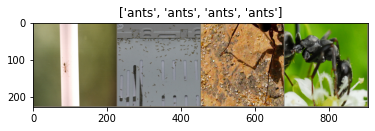

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#### Training the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from ``torch.optim.lr_scheduler``.




In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

#### Visualize the model predictions

Generic function to display predictions for a few images

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#### 1. Finetuning the convnet

Load a pretrained model and reset final fully connected layer.

In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/chaklam/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100.0%


#### Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.  I gonna keep it quick so I assign 5 epochs, you should try 25 or more..

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.3262 Acc: 0.8525
val Loss: 0.2320 Acc: 0.9281

Epoch 1/4
----------
train Loss: 0.2201 Acc: 0.9057
val Loss: 0.1899 Acc: 0.9346

Epoch 2/4
----------
train Loss: 0.3610 Acc: 0.8607
val Loss: 0.2106 Acc: 0.9346

Epoch 3/4
----------
train Loss: 0.3958 Acc: 0.8525
val Loss: 0.2158 Acc: 0.9216

Epoch 4/4
----------
train Loss: 0.3237 Acc: 0.8811
val Loss: 0.2124 Acc: 0.9216

Training complete in 7m 41s
Best val Acc: 0.934641


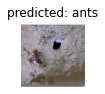

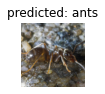

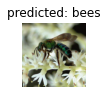

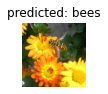

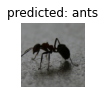

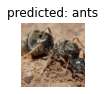

In [11]:
visualize_model(model_ft)

#### 2. ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`.

In [12]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

#### Train and evaluate

On CPU this will take about half the time compared to previous scenario. This is expected as gradients don't need to be computed for most of the network. However, forward does need to be computed.

In [13]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.6300 Acc: 0.6639
val Loss: 0.2865 Acc: 0.8889

Epoch 1/4
----------
train Loss: 0.4606 Acc: 0.7746
val Loss: 0.2430 Acc: 0.9346

Epoch 2/4
----------
train Loss: 0.3575 Acc: 0.8443
val Loss: 0.3811 Acc: 0.8431

Epoch 3/4
----------
train Loss: 0.6712 Acc: 0.7336
val Loss: 0.2463 Acc: 0.9281

Epoch 4/4
----------
train Loss: 0.4228 Acc: 0.7951
val Loss: 0.4137 Acc: 0.8366

Training complete in 5m 19s
Best val Acc: 0.934641


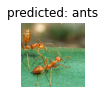

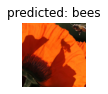

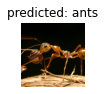

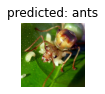

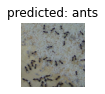

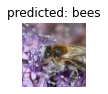

In [14]:
visualize_model(model_conv)

plt.ioff()
plt.show()